# Inventory Monitoring at Distribution Centers
## Problem Statement
Manual Inventory Management requires a huge workforce, and it is also error prone. So, there is a need for an effective inventory management.
Effective Inventory Management enables the business to save time and increase productivity. The automation of this process would eliminate the manual errors, thus saving cost and time. For larger organization, the process is much complicated.
With the recent advancement in the technology, we could solve the above problem with machine automated tasks. The Computer Vision Process aids us in solving the defined problem.
With the huge rise in the demand for inventory management, scalability is a major concerned that affects the long term run of the business. With the automated workflow, scalability becomes much simpler and cost efficient.
The solution can be replicated to different objects with respective datasets for training and the outcomes are measurable with the proposed evaluation metrics.
The problem is identified as a classification problem and upon given an input image from the live camera, the count of the objects in the bin can be predicted using the machine learning model.
This notebook walks through the solution of the identified problem.

### Import Dependencies

In [2]:
import argparse
import numpy as np
import json
import logging
import os
import io
import sys
import matplotlib.pyplot as plt
import requests
from PIL import Image
import json

In [7]:
!pip install torch --no-cache-dir

     |████████████████████████████████| 890.2 MB 53.9 MB/s                           | 229.2 MB 78.7 MB/s eta 0:00:09     | 343.5 MB 19.7 MB/s eta 0:00:28| 765.0 MB 69.2 MB/s eta 0:00:02 MB 53.9 MB/s eta 0:00:01
     |████████████████████████████████| 849 kB 64.8 MB/s            
     |████████████████████████████████| 557.1 MB 71.2 MB/s            
     |████████████████████████████████| 317.1 MB 55.7 MB/s            
     |████████████████████████████████| 21.0 MB 42.6 MB/s            
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
!pip install torchvision --no-cache-dir

     |████████████████████████████████| 24.3 MB 7.3 MB/s            
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
import boto3
import torch
import sagemaker
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

## Data Preparation
The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [10]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))
download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:49,  7.25it/s]

  0%|          | 1/2299 [00:00<04:52,  7.87it/s]

  0%|          | 2/2666 [00:00<03:01, 14.69it/s]

  0%|          | 2/2373 [00:00<02:49, 13.95it/s]

  0%|          | 2/1875 [00:00<02:52, 10.85it/s]

100%|██████████| 1875/1875 [03:07<00:00, 10.02it/s]


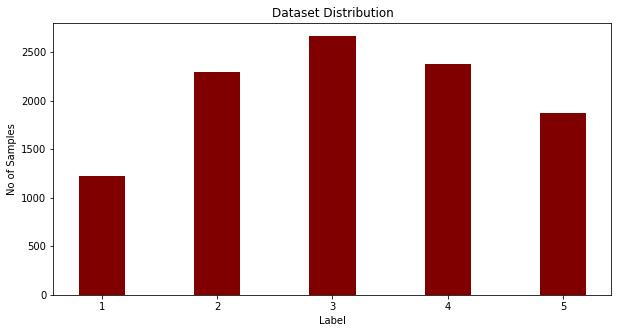

In [11]:
#dataset_count = [1228,2299, 2666, 2373,1875]

import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'1':1228, '2':2299, '3':2666,'4':2373, '5':1875}
object_count = list(data.keys())
no_of_samples = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(object_count, no_of_samples, color ='maroon',width = 0.4)

plt.xlabel("Label")
plt.ylabel("No of Samples")
plt.title("Dataset Distribution")
plt.show()


### Dataset
**The Amazon Bin Image Dataset is to be used to train the model.**
It contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations.
Documentation about the open source dataset can be found [here](https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds).

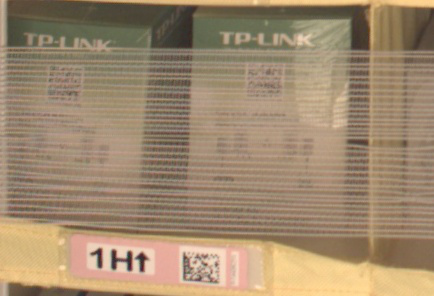

In [12]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/559.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [13]:
os.environ['SM_CHANNEL_TRAINING']='s3://capsto/'
os.environ['SM_MODEL_DIR']='s3://capsto/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://capsto/'

In [14]:
%%capture
!aws s3 cp train_data s3://capsto/ --recursive

In [15]:
role = sagemaker.get_execution_role()

In [16]:
role

'arn:aws:iam::019348503021:role/service-role/AmazonSageMaker-ExecutionRole-20221105T103236'

In [17]:
sagemaker_session = sagemaker.Session()

## Model Training

**Note:** `train.py` script is used to train your model.

In [18]:
# Declare model training hyperparameter.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([10,15, 25 , 30 ])
}

In [19]:
role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [20]:
# Create  training estimator
estimator = PyTorch(
    entry_point="tuner.py",
    base_job_name='pytorch_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    py_version='py3'
)

### Hyperparameter Tuning

In [21]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [27]:
# TODO: Fit your estimator
tuner.fit({"training": "s3://capsto/"})

...........................................................................................................................................................................................................................................................................................................................................................!


In [28]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-221106-0153',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:019348503021:hyper-parameter-tuning-job/pytorch-training-221106-0153',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 2,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"']},
    {'Name': 'epochs', 'Values': ['"10"', '"15"', '"25"', '"30"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_na

In [29]:
tuner.describe().keys()

dict_keys(['HyperParameterTuningJobName', 'HyperParameterTuningJobArn', 'HyperParameterTuningJobConfig', 'TrainingJobDefinition', 'HyperParameterTuningJobStatus', 'CreationTime', 'HyperParameterTuningEndTime', 'LastModifiedTime', 'TrainingJobStatusCounters', 'ObjectiveStatusCounters', 'BestTrainingJob', 'ResponseMetadata'])

In [31]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-training-221106-0153'

#### Find the best Hyperparameter

In [32]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=tuner.describe()['HyperParameterTuningJobName'])

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""","""30""",0.006986,pytorch-training-221106-0153-002-867441fd,Completed,50.0,2022-11-06 01:55:23+00:00,2022-11-06 02:21:41+00:00,1578.0
1,"""32""","""10""",0.001841,pytorch-training-221106-0153-001-37f7c007,Completed,47.0,2022-11-06 01:55:30+00:00,2022-11-06 02:21:45+00:00,1575.0


In [33]:
TrainingJobName= 'pytorch-training-221106-0153-002-867441fd'

In [34]:
best_estimator = sagemaker.estimator.Estimator.attach(TrainingJobName)


2022-11-06 02:21:43 Starting - Preparing the instances for training
2022-11-06 02:21:43 Downloading - Downloading input data
2022-11-06 02:21:43 Training - Training image download completed. Training in progress.
2022-11-06 02:21:43 Uploading - Uploading generated training model
2022-11-06 02:21:43 Completed - Resource retained for reuse


In [35]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"64"',
 'epochs': '"30"',
 'learning_rate': '0.006986428359716793',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_hpo-2022-11-06-01-53-37-439"',
 'sagemaker_program': '"tuner.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-019348503021/pytorch_hpo-2022-11-06-01-53-37-439/source/sourcedir.tar.gz"'}

In [36]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": 0.0012926079994672864, \
                   "epochs" : 25
                                  }
hyperparameters

{'batch_size': 64, 'learning_rate': 0.0012926079994672864, 'epochs': 25}

### Model Profiling and Debugging

In [37]:
# Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1",
    }
)


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)

In [38]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_config_list = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]


hook_config = DebuggerHookConfig(
    # hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
    collection_configs=collection_config_list
)

In [50]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',
    base_job_name='Training-job',
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [ ]:
estimator.fit({"training": "s3://capsto/"}, wait=True)

2022-11-07 03:14:00 Starting - Starting the training job.LossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: Error
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: Error
PoorWeightInitialization: IssuesFound
train loss: 49.0000, acc: 8.0000, best loss: 1000000.0000
valid loss: 47.0000, acc: 9.0000, best loss: 47.0000
Epoch: 1
train loss: 46.0000, acc: 9.0000, best loss: 47.0000
valid loss: 46.0000, acc: 10.0000, best loss: 46.0000
Epoch: 2
train loss: 46.0000, acc: 10.0000, best loss: 46.0000
valid loss: 46.0000, acc: 9.0000, best loss: 46.0000
Testing Model
Testing Loss: 46.0
Testing Accuracy: 9.0
Saving Model
2022-11-07 04:18:22,768 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2022-11-07 04:19:02 Uploading - Uploading generated training model
2022-11-07 04:19:02 Completed - Training job completed
Training seconds: 3785
Billable seconds: 3785


In [57]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-11-07 04:59:29.535 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-019348503021/Training-job-2022-11-07-03-14-00-182/debug-output
[2022-11-07 04:59:29.938 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 214 more expected)', IncompleteRead(0 bytes read, 214 more expected)) while reading s3://sagemaker-us-east-1-019348503021/Training-job-2022-11-07-03-14-00-182/debug-output/index/000000000/000000000100_worker_0.json . Will retry now
[2022-11-07 04:59:32.963 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-11-07 04:59:33.985 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 'layer3.4.relu_input_2',
 'layer3.5.relu_input_0',
 'layer3

In [58]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

74

In [59]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [60]:
steps_eval, vals_eval = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.EVAL)
vals_eval

[array(1.3737185, dtype=float32),
 array(1.4396068, dtype=float32),
 array(1.5180824, dtype=float32),
 array(1.3985754, dtype=float32),
 array(1.354606, dtype=float32),
 array(1.491484, dtype=float32),
 array(1.428181, dtype=float32),
 array(1.4087396, dtype=float32),
 array(1.4251477, dtype=float32),
 array(1.5995746, dtype=float32),
 array(1.5343902, dtype=float32),
 array(1.4232993, dtype=float32),
 array(1.3207632, dtype=float32),
 array(1.5737737, dtype=float32),
 array(1.5902646, dtype=float32),
 array(1.4582042, dtype=float32),
 array(1.3571595, dtype=float32),
 array(1.691139, dtype=float32),
 array(1.4564432, dtype=float32),
 array(1.5386095, dtype=float32),
 array(1.3867165, dtype=float32),
 array(1.4097527, dtype=float32),
 array(1.4685564, dtype=float32),
 array(1.4769616, dtype=float32),
 array(1.5016286, dtype=float32),
 array(1.3165628, dtype=float32),
 array(1.5328206, dtype=float32),
 array(1.3031225, dtype=float32),
 array(1.4792427, dtype=float32),
 array(1.4764409, 

In [61]:
steps_train, vals_train = get_data(trial, tensor_name="CrossEntropyLoss_output_0", mode=ModeKeys.TRAIN)
vals_train

[array(1.6255455, dtype=float32),
 array(1.639918, dtype=float32),
 array(1.518314, dtype=float32),
 array(1.4955682, dtype=float32),
 array(1.583452, dtype=float32),
 array(1.6267033, dtype=float32),
 array(1.5551364, dtype=float32),
 array(1.4549786, dtype=float32),
 array(1.5341076, dtype=float32),
 array(1.459804, dtype=float32),
 array(1.5858734, dtype=float32),
 array(1.5001072, dtype=float32),
 array(1.4617844, dtype=float32),
 array(1.388434, dtype=float32),
 array(1.4146678, dtype=float32),
 array(1.4995114, dtype=float32),
 array(1.5099931, dtype=float32),
 array(1.5919336, dtype=float32),
 array(1.4762944, dtype=float32),
 array(1.4633274, dtype=float32),
 array(1.3771626, dtype=float32),
 array(1.6368998, dtype=float32),
 array(1.4922322, dtype=float32),
 array(1.4833148, dtype=float32),
 array(1.3607495, dtype=float32),
 array(1.4508318, dtype=float32),
 array(1.5071659, dtype=float32),
 array(1.4979819, dtype=float32),
 array(1.5065459, dtype=float32),
 array(1.6707602, d

[2022-11-07 05:00:29.922 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-019348503021/Training-job-2022-11-07-03-14-00-182/debug-output
[2022-11-07 05:00:30.186 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 4377 more expected)', IncompleteRead(0 bytes read, 4377 more expected)) while reading s3://sagemaker-us-east-1-019348503021/Training-job-2022-11-07-03-14-00-182/debug-output/index/000000000/000000000200_worker_0.json . Will retry now
[2022-11-07 05:00:32.863 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-11-07 05:00:33.886 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:40 INFO trial.py:210] Loaded all steps


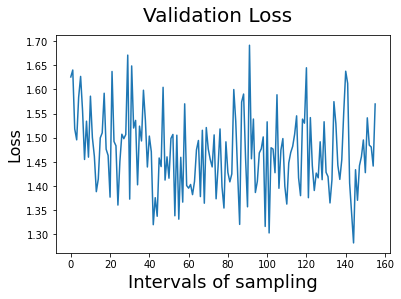

In [62]:
import matplotlib.pyplot as plt


from smdebug.trials import create_trial
from smdebug import modes
import numpy as np
import matplotlib.pyplot as plt


# Get the tensors from S3
s3_output_path = estimator.latest_job_debugger_artifacts_path()

# Create a Trial https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#Trial
trial = create_trial(s3_output_path)

# Get all the tensor names
trial.tensor_names()

# Get the values of the tensor `val_acc`for mode GLOBAL (validation accuracy)
values = trial.tensor("CrossEntropyLoss_output_0").values(modes.GLOBAL)

# Convert it to numpy array
values_eval = np.array(list(values.items()))

fig = plt.figure()
plt.plot(values_eval[:, 1])
fig.suptitle('Validation Loss', fontsize=20)
plt.xlabel('Intervals of sampling', fontsize=18)
plt.ylabel('Loss', fontsize=16)
fig.savefig('validation_loss.jpg')

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("Train Data Loaded")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("Eval Data Loaded")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Generated TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Generated EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()


Train Data Loaded
Eval Data Loaded
Generated TRAIN plot
Generated EVAL plot


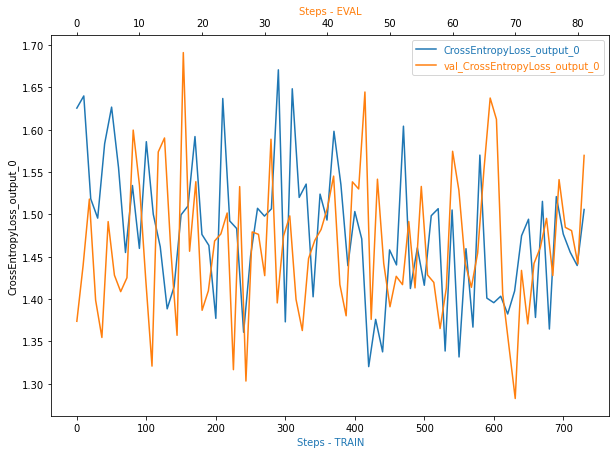

In [64]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Profiler Report

In [65]:
# Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-019348503021/Training-job-2022-11-07-03-14-00-182/rule-output
2022-11-07 04:18:52     329706 Training-job-2022-11-07-03-14-00-182/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-11-07 04:18:52     171068 Training-job-2022-11-07-03-14-00-182/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-11-07 04:18:48        192 Training-job-2022-11-07-03-14-00-182/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-11-07 04:18:48        200 Training-job-2022-11-07-03-14-00-182/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-07 04:18:48        126 Training-job-2022-11-07-03-14-00-182/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-11-07 04:18:48        127 Training-job-2022-11-07-03-14-00-182/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-11-07 04:18:48       

In [66]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [67]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deployment

In [68]:
estimator.model_data

's3://sagemaker-us-east-1-019348503021/Training-job-2022-11-07-03-14-00-182/output/model.tar.gz'

In [69]:
model_location=estimator.model_data

In [70]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [71]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [72]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

### Model Querying

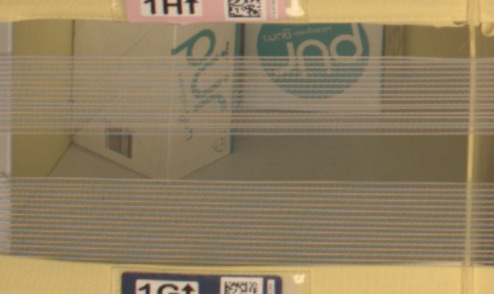

In [73]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [74]:
from IPython.display import Image

In [75]:
response=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [77]:
response[0]

[1.346423625946045,
 0.632469892501831,
 0.09672486037015915,
 -0.749921977519989,
 -1.398074746131897]

In [78]:
np.argmax(response, 1)

array([0])

### Multi-Instance Training

#### No of Instnaces used for Training - 2

In [ ]:
# Train your model on Multiple Instances
multi_instance = PyTorch(
    base_job_name="Multi-instance-job",
    sagemaker_session=sagemaker_session,
    entry_point="train.py",
    role=role,
    framework_version="1.4.0",
    py_version="py3",
    instance_count=2,
    instance_type="ml.m4.xlarge",
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
multi_instance.fit({"training": "s3://capsto/"}, wait=True)

2022-11-07 05:04:53 Starting - Starting the training job...
2022-11-07 05:05:23 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
............
2022-11-07 05:07:24 Downloading - Downloading input data......
2022-11-07 05:08:24 Training - Downloading the training image...
2022-11-07 05:08:44 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-07 05:08:43,049 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-07 05:08:43,053 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-11-07 05:08:43,067 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-07 05:08:43,071 sagemaker_p